# Import Library

In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns

# library time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose # untuk menguji apakah data kita stasioner atau tidak
from statsmodels.tsa.stattools import adfuller #
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library for forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load Dataset

In [77]:
data = pd.read_excel('CO2 dataset.xlsx')
data

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542
...,...,...
210,2010,15.60000
211,2011,15.60000
212,2012,14.80000
213,2013,14.70000


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [79]:
data.describe()

,Year,CO2
count,215.000000,215.000000
mean,1907.000000,6.741970
std,62.209324,6.522437
min,1800.000000,0.001750
25%,1853.500000,0.041050
50%,1907.000000,6.390000
75%,1960.500000,11.500000
max,2014.000000,18.200000


# Transform Data

In [80]:
# Ubah kolom Year menjadi datetime
data['Year'] = pd.to_datetime(data['Year'], format='%Y')

In [81]:
# Membuat index Year
data.set_index(['Year'], inplace=True)
data

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542
...,...
2010-01-01,15.60000
2011-01-01,15.60000
2012-01-01,14.80000


In [82]:
# cek nilai minimal dan maksimal
data.index.min(), data.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [83]:
# cek apakah data bersifat continous
if (data.index.max() - data.index.min() == 214):
    print('Data is Continous')

In [84]:
# set data frequensi pertahun
data.index.freq = 'YS'

# Analisis Time Series

<AxesSubplot:xlabel='Year'>

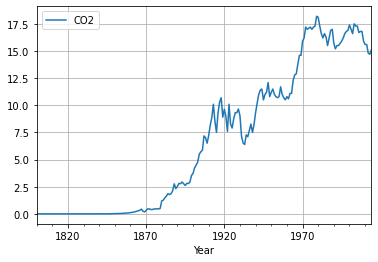

In [85]:
data.plot(grid=True)

In [86]:
# cek apakah datanya stasioner
train_data = data.loc[:'1991-01-01']
test_data = data.loc['1992-01-01':]

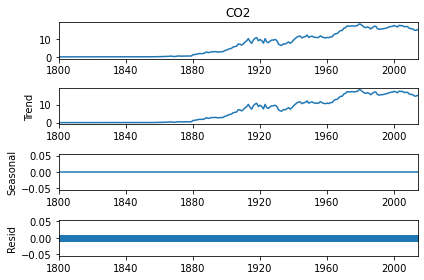

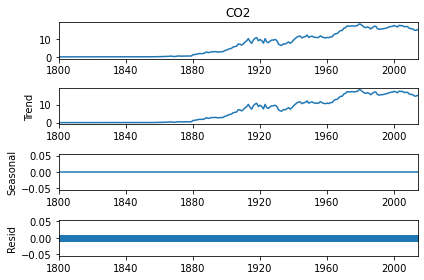

In [87]:
# decompose
decompose_add = seasonal_decompose(data['CO2'])
decompose_add.plot()

In [88]:
# membuat adfuller
def adf_test(timeseries):
    print('Hasil testing Dickey-Fuller')
    print('-----------------------------------')
    adftest =adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic', 'p-value', 'Lags Used', 'Number of Observation Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print(adf_output)
    
adf_test(data.values)

Hasil testing Dickey-Fuller
-----------------------------------
Test statistic                 -0.378463
p-value                         0.913633
Lags Used                       0.000000
Number of Observation Used    214.000000
Critical Value (1%)            -3.461282
Critical Value (5%)            -2.875143
Critical Value (10%)           -2.574020
dtype: float64


In [89]:
# diferensi stasionary
diff_data = data.diff()
diff_data.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [90]:
diff_data.dropna(inplace=True)

<AxesSubplot:xlabel='Year'>

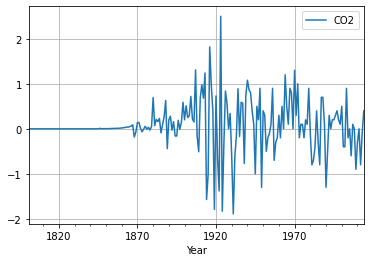

In [91]:
diff_data.plot(grid=True)

Dari Hasil tersebut bisa dibilang cukup stasioner

In [92]:
# panggil adfuller test
adf_test(diff_data)

Hasil testing Dickey-Fuller
-----------------------------------
Test statistic                 -3.780005
p-value                         0.003119
Lags Used                      15.000000
Number of Observation Used    198.000000
Critical Value (1%)            -3.463815
Critical Value (5%)            -2.876251
Critical Value (10%)           -2.574611
dtype: float64


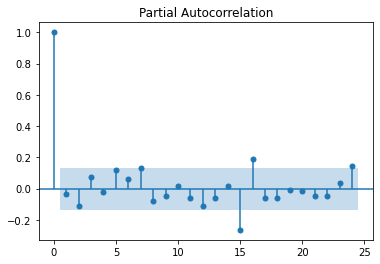

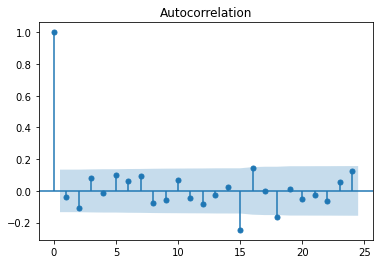

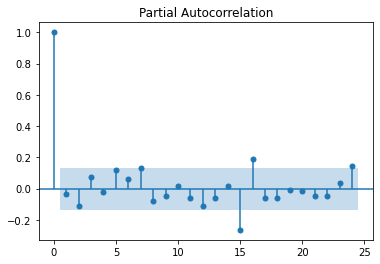

In [93]:
# membuat plot parcial auto corelation dan auto corelation
# untuk melihat apakah datanya stasioner atau tidak
plot_acf(diff_data)
plot_pacf(diff_data)

Dari hasil tersebut, bisa dikatakan datanya sudah stasioner 

# Modelling

### Single Exponential Smoothing

In [100]:
single_exp = SimpleExpSmoothing(train_data).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

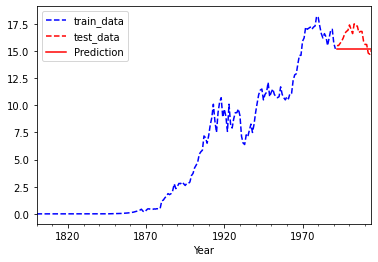

In [101]:
train_data['CO2'].plot(style='--', color='blue', legend=True, 
                       label='train_data')
test_data['CO2'].plot(style='--', color='r', legend=True, 
                      label='test_data')
single_exp_test_pred.plot(color='red', legend=True, label='Prediction')

In [102]:
print('Train RMSE :', mean_squared_error(train_data, single_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_data, single_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_data, single_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_data, single_exp_test_pred))

Train RMSE : 0.5646920026800123
Test RMSE : 1.3429113022699568
Train MAPE : 0.08470523420388641
Test MAPE : 0.06861466412076216


### Double Exponential Smoothing

In [103]:
double_exp = ExponentialSmoothing(train_data, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

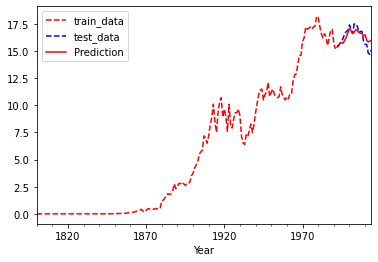

In [110]:
train_data['CO2'].plot(style='--', color='red', legend=True, 
                       label='train_data')
test_data['CO2'].plot(style='--', color='blue', legend=True, 
                      label='test_data')
double_exp_test_pred.plot(color='red', legend=True, label='Prediction')

In [109]:
print('Train RMSE :', mean_squared_error(train_data, double_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_data, double_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_data, double_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_data, double_exp_test_pred))

Train RMSE : 0.5219963053031166
Test RMSE : 0.5352724337295782
Train MAPE : 12.80676209367828
Test MAPE : 0.026063835325023245


### ARIMA

In [111]:
ar = ARIMA(train_data, order=(15, 1, 15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Year'>

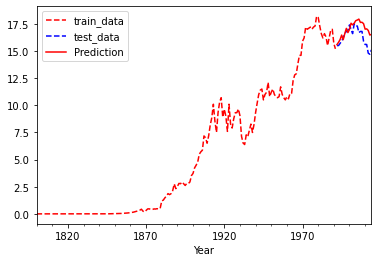

In [112]:
train_data['CO2'].plot(style='--', color='red', legend=True, 
                       label='train_data')
test_data['CO2'].plot(style='--', color='blue', legend=True, 
                      label='test_data')
ar_test_pred.plot(color='red', legend=True, label='Prediction')

In [113]:
print('Train RMSE :', mean_squared_error(train_data, ar_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_data, ar_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_data, ar_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_data, ar_test_pred))

Train RMSE : 0.46782678670784045
Test RMSE : 0.9678850372786176
Train MAPE : 0.08133029945863646
Test MAPE : 0.04803884484200799


# Perbandingan Algoritma

In [115]:
comparision_data = pd.DataFrame(data=[
    ['Single Exp Smoothing', 1.3429, 0.0686],
    ['Double Exp Smoothing', 0.5352, 0.0260],
    ['ARIMA', 0.9549, 0.0472]
    ],
    columns=['Model', 'RMSE', 'MAPE'])
comparision_data.set_index('Model', inplace=True)

In [116]:
comparision_data.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Double Exp Smoothing,0.5352,0.0260
ARIMA,0.9549,0.0472
Single Exp Smoothing,1.3429,0.0686


In [119]:
double_exp = ExponentialSmoothing(data, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(20) # Melakukan forecast 20 tahun kedepan

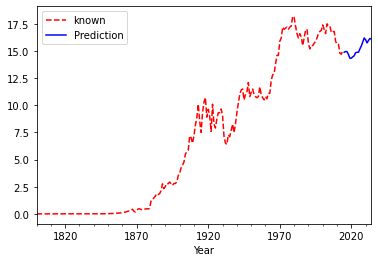

In [120]:
data['CO2'].plot(style='--', color='red', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='Prediction')
plt.show()

In [121]:
import pickle

In [122]:
pickle.dump(double_exp, open('forecast_CO2.sav', 'wb'))